In [2]:
import datetime as dt
import logging
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import torch
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayStandardScaler, SeasonalFeatures, XArrayFeatureUnion
from src.step3_modeling.ensemble import DefaultEnsemble, BaggedXArrayRegressor
from src.step3_modeling.gaussian_process import SklearnGPModel, LaggedSklearnGP, MultitaskGP
from src.step3_modeling.var_models import VAR, NARX
from src.step3_modeling.metrics import summarize
from src.utils import create_rnbs_snapshot, flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [3]:
lake_data = (load_data(["rnbs", "precip", "temp", "evap"]).
             sel(type="Basin").
             dropna("Date").
             to_array().
             transpose("Date", "lake", ...)
             )
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4)>
array([[[-20.92372 ,  24.8     , 266.2     ,  29.08    ],
        [ 40.5714  ,  42.78    , 266.3     ,  40.95    ],
        [ 93.83467 ,  13.33    , 258.3     ,  57.94    ],
        [239.5306  ,  46.5     , 526.5     ,  89.74    ]],

       [[ 33.66357 ,  14.56    , 263.9     ,  24.95    ],
        [ 39.75065 ,  16.8     , 261.1     ,  35.42    ],
        [145.7005  ,  16.8     , 258.4     ,  34.3     ],
        [ 92.36002 ,  24.92    , 522.4     ,  68.1     ]],

       [[139.9274  ,  28.21    , 274.2     ,  29.88    ],
        [234.0305  ,  22.32    , 274.2     ,  32.27    ],
        [278.341   ,  35.03    , 267.1     ,  35.06    ],
        [446.8436  ,  68.2     , 541.7     ,  59.49    ]],

       ...,

       [[-34.00105 ,  18.29    , 285.3     ,  55.55    ],
        [-47.44791 ,  23.25    , 283.6     ,  62.46    ],
        [-45.33585 ,  19.84    , 280.5     ,  53.57    ],
        [116.2634  ,  32.24    , 566.2     , 120.5     ]],

       [[  3.796643,  27.6     , 278.5     ,  37.59    ],
        [-13.97484 ,  26.7     , 277.3     ,  45.81    ],
        [-10.20312 ,  25.2     , 274.1     ,  54.42    ],
        [142.3357  ,  37.5     , 553.3     , 100.35    ]],

       [[-53.29011 ,  16.12    , 269.9     ,  42.62    ],
        [ -2.97982 ,  28.83    , 269.4     ,  53.72    ],
        [  0.      ,  13.64    , 266.5     ,  59.74    ],
        [173.6947  ,  35.34    , 538.      , 114.91    ]]])
Coordinates:
  * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 'sup' 'mic_hur' 'eri' 'ont'
    type      <U5 'Basin'
  * variable  (variable) object 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [4]:
num_splits = 12
forecast_steps = 6
splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps)

splits = list(splitter.split(lake_data))

X, y = lake_data.sel(variable=["precip", "temp", "evap"]).drop("type"), lake_data.sel(variable=["rnbs"]).squeeze().drop(
    ["type", "variable"])

y = XArrayStandardScaler().fit_transform(y)
X, y


(<xarray.DataArray (Date: 384, lake: 4, variable: 3)>
 array([[[ 24.8 , 266.2 ,  29.08],
         [ 42.78, 266.3 ,  40.95],
         [ 13.33, 258.3 ,  57.94],
         [ 46.5 , 526.5 ,  89.74]],
 
        [[ 14.56, 263.9 ,  24.95],
         [ 16.8 , 261.1 ,  35.42],
         [ 16.8 , 258.4 ,  34.3 ],
         [ 24.92, 522.4 ,  68.1 ]],
 
        [[ 28.21, 274.2 ,  29.88],
         [ 22.32, 274.2 ,  32.27],
         [ 35.03, 267.1 ,  35.06],
         [ 68.2 , 541.7 ,  59.49]],
 
        ...,
 
        [[ 18.29, 285.3 ,  55.55],
         [ 23.25, 283.6 ,  62.46],
         [ 19.84, 280.5 ,  53.57],
         [ 32.24, 566.2 , 120.5 ]],
 
        [[ 27.6 , 278.5 ,  37.59],
         [ 26.7 , 277.3 ,  45.81],
         [ 25.2 , 274.1 ,  54.42],
         [ 37.5 , 553.3 , 100.35]],
 
        [[ 16.12, 269.9 ,  42.62],
         [ 28.83, 269.4 ,  53.72],
         [ 13.64, 266.5 ,  59.74],
         [ 35.34, 538.  , 114.91]]])
 Coordinates:
   * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 .

In [5]:
preprocessor = XArrayFeatureUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayStandardScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

gp_models = {
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "GP_MaternLag": Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", LaggedSklearnGP(
                                        1.0 * kernels.Matern(
                                            nu=1.5) * kernels.RationalQuadratic()
                                    ))
                                    ]),
    "MultitaskGP": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", MultitaskGP(epochs=100))
    ]),
}

varx_models = {
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip": 2, "temp": 2, "evap": 3}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),
    "NARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            NARX(lags={"y": 3, "temp": 2, "precip": 2, "evap": 3}, num_warmup=3000, num_chains=4, num_samples=1000)
        )
    ]),
}

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    **gp_models,
    **varx_models,
}



In [6]:
# for name, model in all_models.items():
train_id, test_id = splits[0]

# run cross validated
results = []
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
        # X[train_id], y[train_id]
        model.fit(X[train_id], y[train_id])
        preds = model.predict(X[:max(test_id) + 1], y=y[:max(test_id) + 1], forecast_steps=forecast_steps)

        array = xr.concat([
            preds,
            y[test_id].expand_dims({"value": ["true"]}, axis=-1)
        ], dim="value")

        predictions = pd.concat([
            arr.to_pandas().assign(months_ahead=list(range(1, forecast_steps + 1)), model=name)
            for arr in array.transpose("lake", ...)
        ], axis=0, keys=preds.lake.values, names=["lake"])
        results.append(predictions)

cv_results = pd.concat(results, axis=0)


INFO:root:Fitting Default model...
INFO:root:Fitting Default model (split 1/12)
INFO:root:Fitting Default model (split 2/12)
INFO:root:Fitting Default model (split 3/12)
INFO:root:Fitting Default model (split 4/12)
INFO:root:Fitting Default model (split 5/12)
INFO:root:Fitting Default model (split 6/12)
INFO:root:Fitting Default model (split 7/12)
INFO:root:Fitting Default model (split 8/12)
INFO:root:Fitting Default model (split 9/12)
INFO:root:Fitting Default model (split 10/12)
INFO:root:Fitting Default model (split 11/12)
INFO:root:Fitting Default model (split 12/12)
INFO:root:Fitting GP_Matern model...
INFO:root:Fitting GP_Matern model (split 1/12)
INFO:root:Fitting GP_Matern model (split 2/12)
INFO:root:Fitting GP_Matern model (split 3/12)
INFO:root:Fitting GP_Matern model (split 4/12)
INFO:root:Fitting GP_Matern model (split 5/12)
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value f

Iter 1/100 - Loss: 1.782
Iter 2/100 - Loss: 1.721
Iter 3/100 - Loss: 1.658
Iter 4/100 - Loss: 1.595
Iter 5/100 - Loss: 1.534
Iter 6/100 - Loss: 1.475
Iter 7/100 - Loss: 1.420
Iter 8/100 - Loss: 1.369
Iter 9/100 - Loss: 1.321
Iter 10/100 - Loss: 1.274
Iter 11/100 - Loss: 1.227
Iter 12/100 - Loss: 1.178
Iter 13/100 - Loss: 1.127
Iter 14/100 - Loss: 1.075
Iter 15/100 - Loss: 1.021
Iter 16/100 - Loss: 0.967
Iter 17/100 - Loss: 0.913
Iter 18/100 - Loss: 0.862
Iter 19/100 - Loss: 0.813
Iter 20/100 - Loss: 0.768
Iter 21/100 - Loss: 0.730
Iter 22/100 - Loss: 0.700
Iter 23/100 - Loss: 0.679
Iter 24/100 - Loss: 0.666
Iter 25/100 - Loss: 0.658
Iter 26/100 - Loss: 0.646
Iter 27/100 - Loss: 0.630
Iter 28/100 - Loss: 0.613
Iter 29/100 - Loss: 0.598
Iter 30/100 - Loss: 0.587
Iter 31/100 - Loss: 0.579
Iter 32/100 - Loss: 0.575
Iter 33/100 - Loss: 0.573
Iter 34/100 - Loss: 0.573
Iter 35/100 - Loss: 0.573
Iter 36/100 - Loss: 0.573
Iter 37/100 - Loss: 0.574
Iter 38/100 - Loss: 0.575
Iter 39/100 - Loss: 0

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/torch/csrc/utils/tensor_new.cpp:623.)
INFO:root:Fitting MultitaskGP model (split 2/12)


Iter 1/100 - Loss: 1.829
Iter 2/100 - Loss: 1.763
Iter 3/100 - Loss: 1.698
Iter 4/100 - Loss: 1.635
Iter 5/100 - Loss: 1.576
Iter 6/100 - Loss: 1.520
Iter 7/100 - Loss: 1.465
Iter 8/100 - Loss: 1.409
Iter 9/100 - Loss: 1.352
Iter 10/100 - Loss: 1.295
Iter 11/100 - Loss: 1.239
Iter 12/100 - Loss: 1.183
Iter 13/100 - Loss: 1.129
Iter 14/100 - Loss: 1.075
Iter 15/100 - Loss: 1.023
Iter 16/100 - Loss: 0.973
Iter 17/100 - Loss: 0.928
Iter 18/100 - Loss: 0.888
Iter 19/100 - Loss: 0.853
Iter 20/100 - Loss: 0.820
Iter 21/100 - Loss: 0.789
Iter 22/100 - Loss: 0.759
Iter 23/100 - Loss: 0.730
Iter 24/100 - Loss: 0.701
Iter 25/100 - Loss: 0.675
Iter 26/100 - Loss: 0.651
Iter 27/100 - Loss: 0.629
Iter 28/100 - Loss: 0.611
Iter 29/100 - Loss: 0.598
Iter 30/100 - Loss: 0.588
Iter 31/100 - Loss: 0.582
Iter 32/100 - Loss: 0.579
Iter 33/100 - Loss: 0.578
Iter 34/100 - Loss: 0.578
Iter 35/100 - Loss: 0.578
Iter 36/100 - Loss: 0.577
Iter 37/100 - Loss: 0.577
Iter 38/100 - Loss: 0.577
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 3/12)


Iter 1/100 - Loss: 1.943
Iter 2/100 - Loss: 1.884
Iter 3/100 - Loss: 1.824
Iter 4/100 - Loss: 1.761
Iter 5/100 - Loss: 1.697
Iter 6/100 - Loss: 1.631
Iter 7/100 - Loss: 1.562
Iter 8/100 - Loss: 1.492
Iter 9/100 - Loss: 1.421
Iter 10/100 - Loss: 1.350
Iter 11/100 - Loss: 1.281
Iter 12/100 - Loss: 1.215
Iter 13/100 - Loss: 1.154
Iter 14/100 - Loss: 1.098
Iter 15/100 - Loss: 1.043
Iter 16/100 - Loss: 0.988
Iter 17/100 - Loss: 0.934
Iter 18/100 - Loss: 0.881
Iter 19/100 - Loss: 0.830
Iter 20/100 - Loss: 0.782
Iter 21/100 - Loss: 0.742
Iter 22/100 - Loss: 0.714
Iter 23/100 - Loss: 0.698
Iter 24/100 - Loss: 0.682
Iter 25/100 - Loss: 0.657
Iter 26/100 - Loss: 0.631
Iter 27/100 - Loss: 0.609
Iter 28/100 - Loss: 0.593
Iter 29/100 - Loss: 0.584
Iter 30/100 - Loss: 0.580
Iter 31/100 - Loss: 0.579
Iter 32/100 - Loss: 0.578
Iter 33/100 - Loss: 0.577
Iter 34/100 - Loss: 0.575
Iter 35/100 - Loss: 0.574
Iter 36/100 - Loss: 0.572
Iter 37/100 - Loss: 0.571
Iter 38/100 - Loss: 0.570
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 4/12)


Iter 98/100 - Loss: 0.541
Iter 99/100 - Loss: 0.541
Iter 100/100 - Loss: 0.541
Iter 1/100 - Loss: 1.713
Iter 2/100 - Loss: 1.641
Iter 3/100 - Loss: 1.570
Iter 4/100 - Loss: 1.502
Iter 5/100 - Loss: 1.440
Iter 6/100 - Loss: 1.383
Iter 7/100 - Loss: 1.329
Iter 8/100 - Loss: 1.277
Iter 9/100 - Loss: 1.225
Iter 10/100 - Loss: 1.175
Iter 11/100 - Loss: 1.123
Iter 12/100 - Loss: 1.070
Iter 13/100 - Loss: 1.017
Iter 14/100 - Loss: 0.965
Iter 15/100 - Loss: 0.915
Iter 16/100 - Loss: 0.871
Iter 17/100 - Loss: 0.831
Iter 18/100 - Loss: 0.798
Iter 19/100 - Loss: 0.771
Iter 20/100 - Loss: 0.747
Iter 21/100 - Loss: 0.721
Iter 22/100 - Loss: 0.693
Iter 23/100 - Loss: 0.666
Iter 24/100 - Loss: 0.645
Iter 25/100 - Loss: 0.627
Iter 26/100 - Loss: 0.612
Iter 27/100 - Loss: 0.599
Iter 28/100 - Loss: 0.588
Iter 29/100 - Loss: 0.579
Iter 30/100 - Loss: 0.571
Iter 31/100 - Loss: 0.565
Iter 32/100 - Loss: 0.561
Iter 33/100 - Loss: 0.559
Iter 34/100 - Loss: 0.558
Iter 35/100 - Loss: 0.558
Iter 36/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 5/12)


Iter 1/100 - Loss: 1.886
Iter 2/100 - Loss: 1.829
Iter 3/100 - Loss: 1.771
Iter 4/100 - Loss: 1.711
Iter 5/100 - Loss: 1.648
Iter 6/100 - Loss: 1.583
Iter 7/100 - Loss: 1.516
Iter 8/100 - Loss: 1.449
Iter 9/100 - Loss: 1.380
Iter 10/100 - Loss: 1.312
Iter 11/100 - Loss: 1.244
Iter 12/100 - Loss: 1.176
Iter 13/100 - Loss: 1.111
Iter 14/100 - Loss: 1.049
Iter 15/100 - Loss: 0.992
Iter 16/100 - Loss: 0.939
Iter 17/100 - Loss: 0.890
Iter 18/100 - Loss: 0.843
Iter 19/100 - Loss: 0.799
Iter 20/100 - Loss: 0.759
Iter 21/100 - Loss: 0.724
Iter 22/100 - Loss: 0.698
Iter 23/100 - Loss: 0.680
Iter 24/100 - Loss: 0.665
Iter 25/100 - Loss: 0.644
Iter 26/100 - Loss: 0.622
Iter 27/100 - Loss: 0.604
Iter 28/100 - Loss: 0.592
Iter 29/100 - Loss: 0.585
Iter 30/100 - Loss: 0.580
Iter 31/100 - Loss: 0.577
Iter 32/100 - Loss: 0.575
Iter 33/100 - Loss: 0.574
Iter 34/100 - Loss: 0.574
Iter 35/100 - Loss: 0.575
Iter 36/100 - Loss: 0.576
Iter 37/100 - Loss: 0.576
Iter 38/100 - Loss: 0.577
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 6/12)


Iter 97/100 - Loss: 0.544
Iter 98/100 - Loss: 0.544
Iter 99/100 - Loss: 0.544
Iter 100/100 - Loss: 0.544
Iter 1/100 - Loss: 1.782
Iter 2/100 - Loss: 1.722
Iter 3/100 - Loss: 1.666
Iter 4/100 - Loss: 1.610
Iter 5/100 - Loss: 1.552
Iter 6/100 - Loss: 1.494
Iter 7/100 - Loss: 1.433
Iter 8/100 - Loss: 1.373
Iter 9/100 - Loss: 1.312
Iter 10/100 - Loss: 1.251
Iter 11/100 - Loss: 1.191
Iter 12/100 - Loss: 1.132
Iter 13/100 - Loss: 1.076
Iter 14/100 - Loss: 1.021
Iter 15/100 - Loss: 0.969
Iter 16/100 - Loss: 0.921
Iter 17/100 - Loss: 0.878
Iter 18/100 - Loss: 0.838
Iter 19/100 - Loss: 0.800
Iter 20/100 - Loss: 0.765
Iter 21/100 - Loss: 0.734
Iter 22/100 - Loss: 0.706
Iter 23/100 - Loss: 0.681
Iter 24/100 - Loss: 0.660
Iter 25/100 - Loss: 0.641
Iter 26/100 - Loss: 0.622
Iter 27/100 - Loss: 0.605
Iter 28/100 - Loss: 0.591
Iter 29/100 - Loss: 0.581
Iter 30/100 - Loss: 0.573
Iter 31/100 - Loss: 0.567
Iter 32/100 - Loss: 0.564
Iter 33/100 - Loss: 0.563
Iter 34/100 - Loss: 0.564
Iter 35/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 7/12)


Iter 1/100 - Loss: 1.974
Iter 2/100 - Loss: 1.914
Iter 3/100 - Loss: 1.850
Iter 4/100 - Loss: 1.785
Iter 5/100 - Loss: 1.721
Iter 6/100 - Loss: 1.660
Iter 7/100 - Loss: 1.603
Iter 8/100 - Loss: 1.546
Iter 9/100 - Loss: 1.489
Iter 10/100 - Loss: 1.429
Iter 11/100 - Loss: 1.367
Iter 12/100 - Loss: 1.303
Iter 13/100 - Loss: 1.239
Iter 14/100 - Loss: 1.175
Iter 15/100 - Loss: 1.112
Iter 16/100 - Loss: 1.051
Iter 17/100 - Loss: 0.992
Iter 18/100 - Loss: 0.936
Iter 19/100 - Loss: 0.885
Iter 20/100 - Loss: 0.838
Iter 21/100 - Loss: 0.793
Iter 22/100 - Loss: 0.750
Iter 23/100 - Loss: 0.708
Iter 24/100 - Loss: 0.667
Iter 25/100 - Loss: 0.633
Iter 26/100 - Loss: 0.608
Iter 27/100 - Loss: 0.596
Iter 28/100 - Loss: 0.588
Iter 29/100 - Loss: 0.578
Iter 30/100 - Loss: 0.573
Iter 31/100 - Loss: 0.572
Iter 32/100 - Loss: 0.574
Iter 33/100 - Loss: 0.576
Iter 34/100 - Loss: 0.577
Iter 35/100 - Loss: 0.577
Iter 36/100 - Loss: 0.577
Iter 37/100 - Loss: 0.576
Iter 38/100 - Loss: 0.575
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 8/12)


Iter 100/100 - Loss: 0.541
Iter 1/100 - Loss: 1.614
Iter 2/100 - Loss: 1.548
Iter 3/100 - Loss: 1.482
Iter 4/100 - Loss: 1.421
Iter 5/100 - Loss: 1.362
Iter 6/100 - Loss: 1.306
Iter 7/100 - Loss: 1.253
Iter 8/100 - Loss: 1.203
Iter 9/100 - Loss: 1.154
Iter 10/100 - Loss: 1.106
Iter 11/100 - Loss: 1.059
Iter 12/100 - Loss: 1.013
Iter 13/100 - Loss: 0.971
Iter 14/100 - Loss: 0.933
Iter 15/100 - Loss: 0.900
Iter 16/100 - Loss: 0.868
Iter 17/100 - Loss: 0.836
Iter 18/100 - Loss: 0.801
Iter 19/100 - Loss: 0.767
Iter 20/100 - Loss: 0.736
Iter 21/100 - Loss: 0.711
Iter 22/100 - Loss: 0.688
Iter 23/100 - Loss: 0.668
Iter 24/100 - Loss: 0.649
Iter 25/100 - Loss: 0.632
Iter 26/100 - Loss: 0.617
Iter 27/100 - Loss: 0.604
Iter 28/100 - Loss: 0.593
Iter 29/100 - Loss: 0.584
Iter 30/100 - Loss: 0.578
Iter 31/100 - Loss: 0.574
Iter 32/100 - Loss: 0.570
Iter 33/100 - Loss: 0.567
Iter 34/100 - Loss: 0.566
Iter 35/100 - Loss: 0.566
Iter 36/100 - Loss: 0.567
Iter 37/100 - Loss: 0.567
Iter 38/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 9/12)


Iter 1/100 - Loss: 1.850
Iter 2/100 - Loss: 1.782
Iter 3/100 - Loss: 1.713
Iter 4/100 - Loss: 1.641
Iter 5/100 - Loss: 1.568
Iter 6/100 - Loss: 1.495
Iter 7/100 - Loss: 1.422
Iter 8/100 - Loss: 1.352
Iter 9/100 - Loss: 1.283
Iter 10/100 - Loss: 1.218
Iter 11/100 - Loss: 1.156
Iter 12/100 - Loss: 1.097
Iter 13/100 - Loss: 1.040
Iter 14/100 - Loss: 0.986
Iter 15/100 - Loss: 0.934
Iter 16/100 - Loss: 0.888
Iter 17/100 - Loss: 0.846
Iter 18/100 - Loss: 0.809
Iter 19/100 - Loss: 0.776
Iter 20/100 - Loss: 0.744
Iter 21/100 - Loss: 0.714
Iter 22/100 - Loss: 0.688
Iter 23/100 - Loss: 0.666
Iter 24/100 - Loss: 0.649
Iter 25/100 - Loss: 0.634
Iter 26/100 - Loss: 0.620
Iter 27/100 - Loss: 0.606
Iter 28/100 - Loss: 0.594
Iter 29/100 - Loss: 0.585
Iter 30/100 - Loss: 0.578
Iter 31/100 - Loss: 0.573
Iter 32/100 - Loss: 0.570
Iter 33/100 - Loss: 0.568
Iter 34/100 - Loss: 0.566
Iter 35/100 - Loss: 0.565
Iter 36/100 - Loss: 0.564
Iter 37/100 - Loss: 0.565
Iter 38/100 - Loss: 0.567
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 10/12)


Iter 99/100 - Loss: 0.542
Iter 100/100 - Loss: 0.542
Iter 1/100 - Loss: 1.779
Iter 2/100 - Loss: 1.717
Iter 3/100 - Loss: 1.651
Iter 4/100 - Loss: 1.585
Iter 5/100 - Loss: 1.520
Iter 6/100 - Loss: 1.455
Iter 7/100 - Loss: 1.392
Iter 8/100 - Loss: 1.330
Iter 9/100 - Loss: 1.270
Iter 10/100 - Loss: 1.211
Iter 11/100 - Loss: 1.154
Iter 12/100 - Loss: 1.098
Iter 13/100 - Loss: 1.045
Iter 14/100 - Loss: 0.994
Iter 15/100 - Loss: 0.946
Iter 16/100 - Loss: 0.901
Iter 17/100 - Loss: 0.860
Iter 18/100 - Loss: 0.823
Iter 19/100 - Loss: 0.789
Iter 20/100 - Loss: 0.757
Iter 21/100 - Loss: 0.727
Iter 22/100 - Loss: 0.698
Iter 23/100 - Loss: 0.673
Iter 24/100 - Loss: 0.651
Iter 25/100 - Loss: 0.631
Iter 26/100 - Loss: 0.614
Iter 27/100 - Loss: 0.599
Iter 28/100 - Loss: 0.587
Iter 29/100 - Loss: 0.578
Iter 30/100 - Loss: 0.572
Iter 31/100 - Loss: 0.569
Iter 32/100 - Loss: 0.568
Iter 33/100 - Loss: 0.567
Iter 34/100 - Loss: 0.566
Iter 35/100 - Loss: 0.566
Iter 36/100 - Loss: 0.566
Iter 37/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 11/12)


Iter 1/100 - Loss: 1.762
Iter 2/100 - Loss: 1.693
Iter 3/100 - Loss: 1.623
Iter 4/100 - Loss: 1.554
Iter 5/100 - Loss: 1.487
Iter 6/100 - Loss: 1.421
Iter 7/100 - Loss: 1.359
Iter 8/100 - Loss: 1.299
Iter 9/100 - Loss: 1.243
Iter 10/100 - Loss: 1.191
Iter 11/100 - Loss: 1.140
Iter 12/100 - Loss: 1.091
Iter 13/100 - Loss: 1.041
Iter 14/100 - Loss: 0.991
Iter 15/100 - Loss: 0.943
Iter 16/100 - Loss: 0.899
Iter 17/100 - Loss: 0.860
Iter 18/100 - Loss: 0.825
Iter 19/100 - Loss: 0.791
Iter 20/100 - Loss: 0.757
Iter 21/100 - Loss: 0.723
Iter 22/100 - Loss: 0.692
Iter 23/100 - Loss: 0.666
Iter 24/100 - Loss: 0.645
Iter 25/100 - Loss: 0.630
Iter 26/100 - Loss: 0.618
Iter 27/100 - Loss: 0.603
Iter 28/100 - Loss: 0.590
Iter 29/100 - Loss: 0.581
Iter 30/100 - Loss: 0.575
Iter 31/100 - Loss: 0.572
Iter 32/100 - Loss: 0.570
Iter 33/100 - Loss: 0.568
Iter 34/100 - Loss: 0.566
Iter 35/100 - Loss: 0.565
Iter 36/100 - Loss: 0.565
Iter 37/100 - Loss: 0.566
Iter 38/100 - Loss: 0.567
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 12/12)


Iter 1/100 - Loss: 1.831
Iter 2/100 - Loss: 1.768
Iter 3/100 - Loss: 1.704
Iter 4/100 - Loss: 1.642
Iter 5/100 - Loss: 1.578
Iter 6/100 - Loss: 1.512
Iter 7/100 - Loss: 1.444
Iter 8/100 - Loss: 1.376
Iter 9/100 - Loss: 1.308
Iter 10/100 - Loss: 1.242
Iter 11/100 - Loss: 1.178
Iter 12/100 - Loss: 1.117
Iter 13/100 - Loss: 1.056
Iter 14/100 - Loss: 0.998
Iter 15/100 - Loss: 0.941
Iter 16/100 - Loss: 0.888
Iter 17/100 - Loss: 0.842
Iter 18/100 - Loss: 0.805
Iter 19/100 - Loss: 0.778
Iter 20/100 - Loss: 0.759
Iter 21/100 - Loss: 0.737
Iter 22/100 - Loss: 0.708
Iter 23/100 - Loss: 0.678
Iter 24/100 - Loss: 0.651
Iter 25/100 - Loss: 0.629
Iter 26/100 - Loss: 0.612
Iter 27/100 - Loss: 0.599
Iter 28/100 - Loss: 0.588
Iter 29/100 - Loss: 0.580
Iter 30/100 - Loss: 0.574
Iter 31/100 - Loss: 0.571
Iter 32/100 - Loss: 0.569
Iter 33/100 - Loss: 0.568
Iter 34/100 - Loss: 0.567
Iter 35/100 - Loss: 0.566
Iter 36/100 - Loss: 0.565
Iter 37/100 - Loss: 0.565
Iter 38/100 - Loss: 0.567
Iter 39/100 - Loss: 0

INFO:root:Fitting VARX model...
INFO:root:Fitting VARX model (split 1/12)
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 2/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 3/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 4/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 5/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 6/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 7/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 8/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 9/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 10/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 11/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 12/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model...
INFO:root:Fitting NARX model (split 1/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 2/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 3/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 4/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 5/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 6/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 7/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 8/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 9/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 10/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 11/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 12/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
cv_results.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len  \
lake    model                                                                
eri     Default       0.727128  0.527995 -0.026825  0.875000      2.244687   
        GP_Matern     0.420429  0.174586 -0.046636  0.930556      1.553434   
        GP_MaternLag  0.465333  0.213958 -0.050755  0.902778      1.624338   
        MultitaskGP   0.458651  0.207714 -0.051441  0.916667      1.677204   
        NARX          0.464225  0.212280 -0.056788  0.958333      1.770839   
        VARX          0.447427  0.196498 -0.060769  0.888889      1.550310   
mic_hur Default       0.683238  0.457292  0.097579  0.888889      2.222746   
        GP_Matern     0.382363  0.146202  0.000047  0.972222      1.553434   
        GP_MaternLag  0.425676  0.180310  0.029819  0.972222      1.624338   
        MultitaskGP   0.408185  0.166516 -0.009935  0.930556      1.443947   
        NARX          0.405399  0.164302  0.006816  0.958333      1.553345   
        VARX          0.355217  0.124824 -0.036812  0.902778      1.330321   
ont     Default       0.641845  0.398415 -0.116404  0.930556      2.204409   
        GP_Matern     0.433245  0.170544 -0.130987  0.944444      1.553434   
        GP_MaternLag  0.421161  0.170230 -0.084537  0.944444      1.624338   
        MultitaskGP   0.466200  0.195026 -0.149385  0.944444      1.687044   
        NARX          0.429229  0.167986 -0.127483  0.930556      1.676806   
        VARX          0.413989  0.164211 -0.084712  0.916667      1.513275   
sup     Default       0.672807  0.411000  0.204132  0.833333      1.994818   
        GP_Matern     0.439355  0.172416  0.143586  0.902778      1.553434   
        GP_MaternLag  0.430039  0.174832  0.100507  0.902778      1.624338   
        MultitaskGP   0.443553  0.179173  0.132539  0.916667      1.494771   
        NARX          0.416657  0.148830  0.157396  0.916667      1.629831   
        VARX          0.406676  0.156881  0.092217  0.888889      1.295479   

                          crps     N  
lake    model                         
eri     Default       0.409042  72.0  
        GP_Matern     0.237764  72.0  
        GP_MaternLag  0.264131  72.0  
        MultitaskGP   0.257924  72.0  
        NARX          0.261481  72.0  
        VARX          0.250740  72.0  
mic_hur Default       0.399347  72.0  
        GP_Matern     0.211383  72.0  
        GP_MaternLag  0.240125  72.0  
        MultitaskGP   0.224140  72.0  
        NARX          0.226207  72.0  
        VARX          0.205053  72.0  
ont     Default       0.360449  72.0  
        GP_Matern     0.229611  72.0  
        GP_MaternLag  0.225976  72.0  
        MultitaskGP   0.248734  72.0  
        NARX          0.245136  72.0  
        VARX          0.233095  72.0  
sup     Default       0.365079  72.0  
        GP_Matern     0.242923  72.0  
        GP_MaternLag  0.237916  72.0  
        MultitaskGP   0.244905  72.0  
        NARX          0.236253  72.0  
        VARX          0.221956  72.0

In [8]:
cv_results.groupby(["model"]).apply(summarize, include_groups=False)

,rmse,variance,bias,coverage,interval_len,crps,N
model,,,,,,,
Default,0.681939,0.463471,0.039620,0.881944,2.166665,0.383479,288.0
GP_Matern,0.419433,0.175852,-0.008497,0.937500,1.553434,0.230420,288.0
GP_MaternLag,0.435903,0.190010,-0.001242,0.930556,1.624338,0.242037,288.0
MultitaskGP,0.444707,0.197382,-0.019555,0.927083,1.575741,0.243926,288.0
NARX,0.429446,0.184398,-0.005015,0.940972,1.657705,0.242269,288.0
VARX,0.407168,0.165279,-0.022519,0.899306,1.422346,0.227711,288.0


In [9]:
cv_results.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                  
1            Default       0.713942  0.475293 -0.185526  0.895833   
             GP_Matern     0.472579  0.214207 -0.095519  0.895833   
             GP_MaternLag  0.436127  0.183670 -0.080851  0.895833   
             MultitaskGP   0.527867  0.274573 -0.063802  0.812500   
             NARX          0.463505  0.201160 -0.116951  0.916667   
             VARX          0.482098  0.220782 -0.107872  0.854167   
2            Default       0.695546  0.481177  0.051062  0.791667   
             GP_Matern     0.363268  0.120984  0.104782  0.916667   
             GP_MaternLag  0.395755  0.135079  0.146775  0.937500   
             MultitaskGP   0.396395  0.152889  0.065113  0.937500   
             NARX          0.416050  0.159666  0.115896  0.937500   
             VARX          0.390420  0.150656  0.042092  0.916667   
3            Default       0.537387  0.278315  0.102319  0.937500   
             GP_Matern     0.331504  0.108107  0.042277  0.979167   
             GP_MaternLag  0.401984  0.156449  0.071711  0.958333   
             MultitaskGP   0.335803  0.111819  0.030737  1.000000   
             NARX          0.414568  0.166770  0.071389  0.958333   
             VARX          0.370498  0.134928  0.048384  0.895833   
4            Default       0.860412  0.733446  0.082848  0.791667   
             GP_Matern     0.571142  0.319056 -0.084540  0.875000   
             GP_MaternLag  0.596530  0.349602 -0.079032  0.854167   
             MultitaskGP   0.572242  0.323061 -0.066332  0.875000   
             NARX          0.515569  0.263577 -0.047266  0.895833   
             VARX          0.509006  0.258747 -0.018456  0.812500   
5            Default       0.596471  0.290947  0.254619  0.916667   
             GP_Matern     0.402870  0.160263  0.045174  0.958333   
             GP_MaternLag  0.395722  0.151863  0.068792  0.937500   
             MultitaskGP   0.433912  0.188104 -0.013249  0.958333   
             NARX          0.394966  0.153950  0.045253  0.937500   
             VARX          0.353145  0.123826 -0.029759  0.937500   
6            Default       0.641775  0.407305 -0.067600  0.958333   
             GP_Matern     0.319137  0.097860 -0.063159  1.000000   
             GP_MaternLag  0.345257  0.101020 -0.134844  1.000000   
             MultitaskGP   0.349727  0.117437 -0.069800  0.979167   
             NARX          0.353455  0.115246 -0.098409  1.000000   
             VARX          0.297993  0.083970 -0.069501  0.979167   

                           interval_len      crps     N  
months_ahead model                                       
1            Default           1.974050  0.397204  48.0  
             GP_Matern         1.542983  0.268718  48.0  
             GP_MaternLag      1.519138  0.243078  48.0  
             MultitaskGP       1.543606  0.296096  48.0  
             NARX              1.567551  0.252514  48.0  
             VARX              1.333244  0.260702  48.0  
2            Default           1.913799  0.400559  48.0  
             GP_Matern         1.546254  0.198047  48.0  
             GP_MaternLag      1.526061  0.217328  48.0  
             MultitaskGP       1.551895  0.216883  48.0  
             NARX              1.584657  0.227182  48.0  
             VARX              1.406109  0.225067  48.0  
3            Default           2.246366  0.302667  48.0  
             GP_Matern         1.549889  0.188248  48.0  
             GP_MaternLag      1.565235  0.228943  48.0  
             MultitaskGP       1.580328  0.190801  48.0  
             NARX              1.629329  0.240612  48.0  
             VARX              1.425086  0.213201  48.0  
4            Default           2.286621  0.493574  48.0  
             GP_Matern         1.583275  0.319964  48.0  
             GP_MaternLag      1.649143  0.338563  48.0  
             MultitaskGP       1.638199  0.322285  48.0  
             NAR

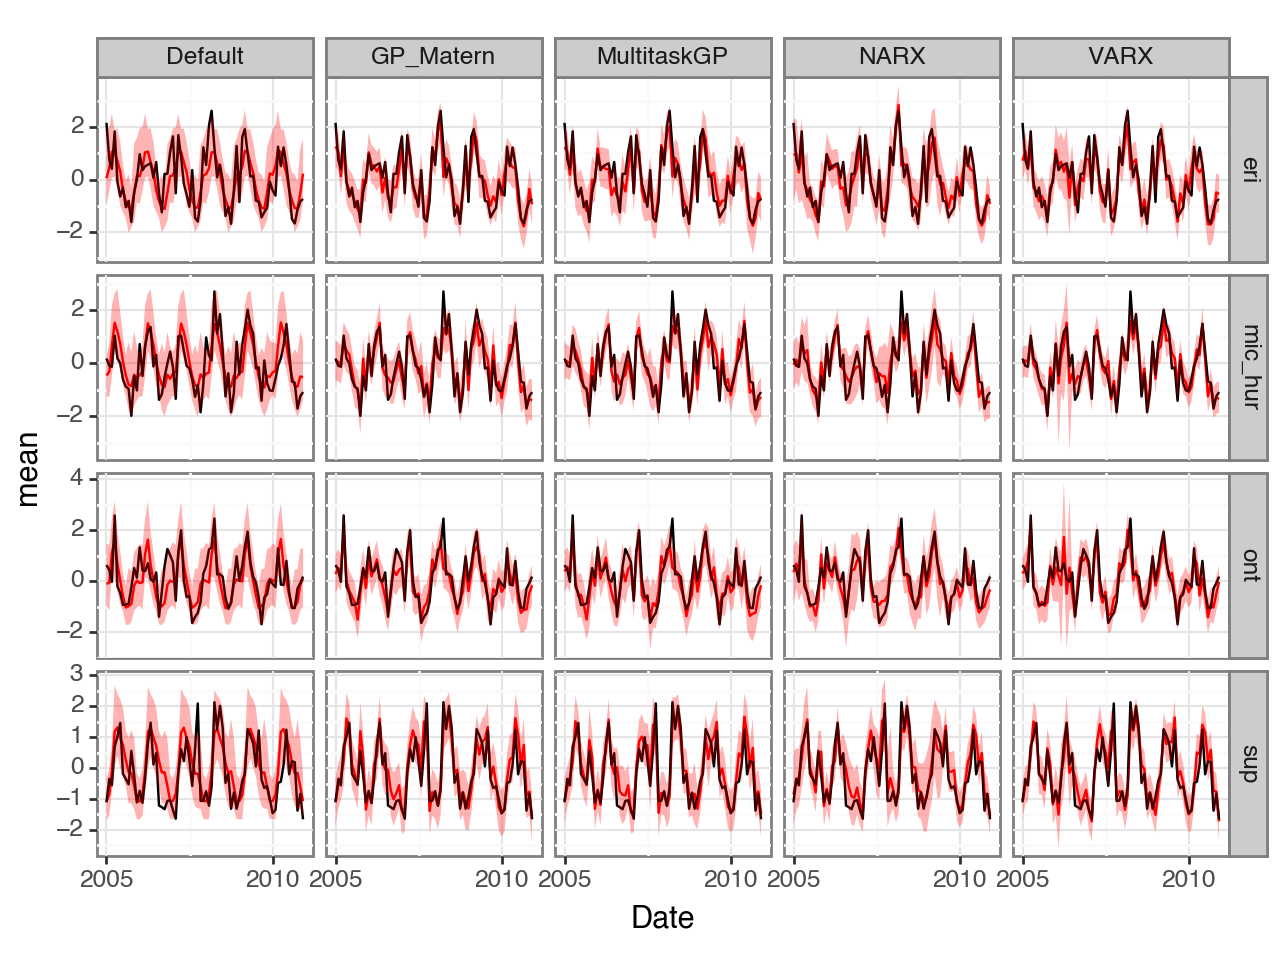

<Figure Size: (640 x 480)>

In [12]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results.reset_index()
plot_data = plot_data[plot_data["model"].isin(["Default", "GP_Matern", "MultitaskGP", "NARX", "VARX"])]
(
        ggplot(data=plot_data.reset_index(), mapping=aes(x="Date", y="mean"))
        + geom_line(color="red")
        + geom_line(mapping=aes(x="Date", y="true"), color="black")
        + facet_grid("lake~model", scales="free_y")
        + scale_x_datetime(
    limits=[plot_data.Date.min(), plot_data.Date.max()],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
)


In [19]:
model = varx_models["VARX"].steps[-1][1]
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["hdi_3%"] <= 0) & (summarized["hdi_97%"] >= 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"evap_alpha[sup, eri, 1]",-0.191,0.039,-0.262,-0.114,0.000,0.000,6458.0,3661.0,1.0
"evap_alpha[mic_hur, ont, 1]",-0.326,0.081,-0.481,-0.181,0.001,0.001,6267.0,3329.0,1.0
"evap_alpha[eri, sup, 1]",-0.247,0.109,-0.444,-0.036,0.002,0.001,4978.0,2979.0,1.0
"evap_alpha[ont, mic_hur, 2]",-0.188,0.087,-0.348,-0.017,0.001,0.001,5745.0,2868.0,1.0
"evap_alpha[ont, ont, 1]",-0.163,0.085,-0.322,-0.004,0.001,0.001,5372.0,3444.0,1.0
"precip_alpha[sup, eri, 1]",0.444,0.025,0.395,0.489,0.000,0.000,6185.0,3223.0,1.0
"precip_alpha[sup, ont, 2]",-0.150,0.046,-0.236,-0.063,0.001,0.000,4737.0,2805.0,1.0
"precip_alpha[mic_hur, eri, 1]",-0.060,0.024,-0.103,-0.014,0.000,0.000,5612.0,3318.0,1.0
"precip_alpha[mic_hur, eri, 2]",-0.073,0.032,-0.135,-0.015,0.000,0.000,4555.0,3483.0,1.0
"precip_alpha[mic_hur, ont, 1]",0.563,0.028,0.510,0.615,0.000,0.000,5195.0,3172.0,1.0


In [ ]:
az.plot_forest(model.trace, var_names=["temp"], filter_vars="regex", figsize=(24, 18))

plt.show()